In [15]:
# ================================================================
# 🪴 Medicinal Leaf Classification - Flask-Ready Model (Fixed)
# Classes: Mango, Neem, Guava, Lemon
# Authors: (Ayuen, Malith, Deng, Biar & Akot)
# ================================================================
# =============================================================================
# 1. ENVIRONMENT SETUP & CONFIGURATION
# =============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, 
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from tensorflow.keras.utils import to_categorical

# Deep Learning
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Architectures
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB7

# Preprocessing Functions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_prep
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_prep

# --- Global Settings ---
CONF = {
    "DATASET_PATH": '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    "TARGET_CLASSES": ['Mango', 'Neem', 'Guava', 'Lemon'],
    "IMG_SIZE": (224, 224),
    "BATCH_SIZE": 16, 
    "EPOCHS": 15,
    "SEED": 42
}

print(f"✅ System Configured. GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ System Configured. GPU Available: True



--- Phase 1: Data Preparation ---
📊 Total Images: 486
   Train: 340 | Val: 73 | Test: 73

--- Visualizing Data Distribution ---


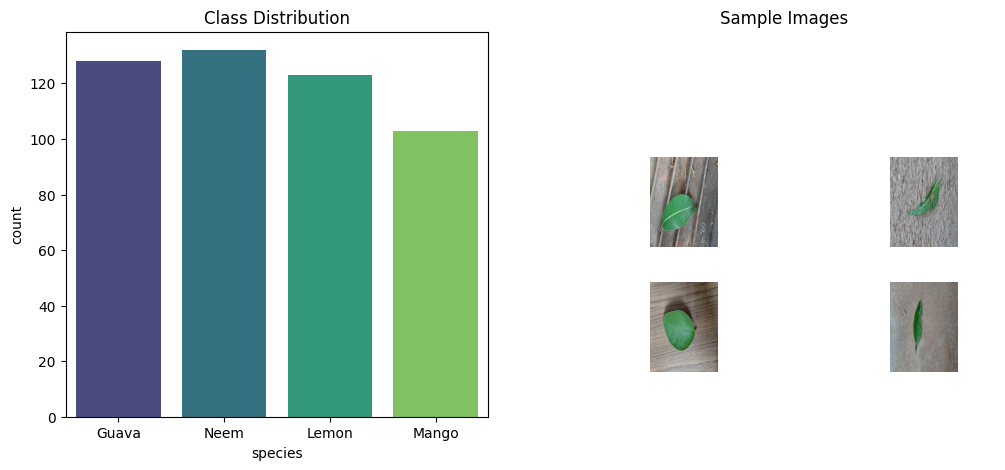

In [16]:
# =============================================================================
# 2. DATA PREPARATION & EDA
# =============================================================================
def load_data_metadata():
    print("\n--- Phase 1: Data Preparation ---")
    filepaths = []
    labels = []

    if not os.path.exists(CONF["DATASET_PATH"]):
        print(f"❌ ERROR: Dataset path not found: {CONF['DATASET_PATH']}")
        return None, None, None
    
    for category in os.listdir(CONF["DATASET_PATH"]):
        if category in CONF["TARGET_CLASSES"]:
            folder_path = os.path.join(CONF["DATASET_PATH"], category)
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                    filepaths.append(os.path.join(folder_path, file))
                    labels.append(category)

    df = pd.DataFrame({'file_path': filepaths, 'species': labels})
    print(f"📊 Total Images: {len(df)}")
    
    # Splits
    train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['species'], random_state=CONF["SEED"])
    val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['species'], random_state=CONF["SEED"])
    
    print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    return train_df, val_df, test_df

train_df, val_df, test_df = load_data_metadata()

# Visualization: Class Distribution & Samples
if train_df is not None:
    print("\n--- Visualizing Data Distribution ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='species', data=pd.concat([train_df, val_df, test_df]), palette='viridis')
    plt.title("Class Distribution")
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title("Sample Images")
    # Display a few samples
    for i, species in enumerate(CONF["TARGET_CLASSES"]):
        sample = train_df[train_df['species'] == species].sample(1).iloc[0]
        img = cv2.imread(sample['file_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.gcf().add_axes([0.55 + (i%2)*0.2, 0.45 - (i//2)*0.25, 0.18, 0.18])
        ax.imshow(img)
        ax.axis('off')
    plt.show()



--- Phase 2: Model Training ---

🔄 Training: Baseline_CNN
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.2342 - loss: 1.3988 - val_accuracy: 0.2740 - val_loss: 1.3787
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.2715 - loss: 1.3832 - val_accuracy: 0.3014 - val_loss: 1.3727
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.2622 - loss: 1.3757 - val_accuracy: 0.2877 - val_loss: 1.3703
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.3393 - loss: 1.3572 - val_accuracy: 0.3836 - val_loss: 1.3467
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.3349 - loss: 1.3571 - val_accuracy: 0.3836 - val_loss: 1.3337
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.3295 - loss: 1.3436 - val_accuracy: 0.4110 - val_loss: 1.3303
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.4174 - loss: 1.2938 - val_accuracy: 0.3425 - val_loss: 1.3922
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.3506 - loss: 1.2874 - val_accuracy: 0.

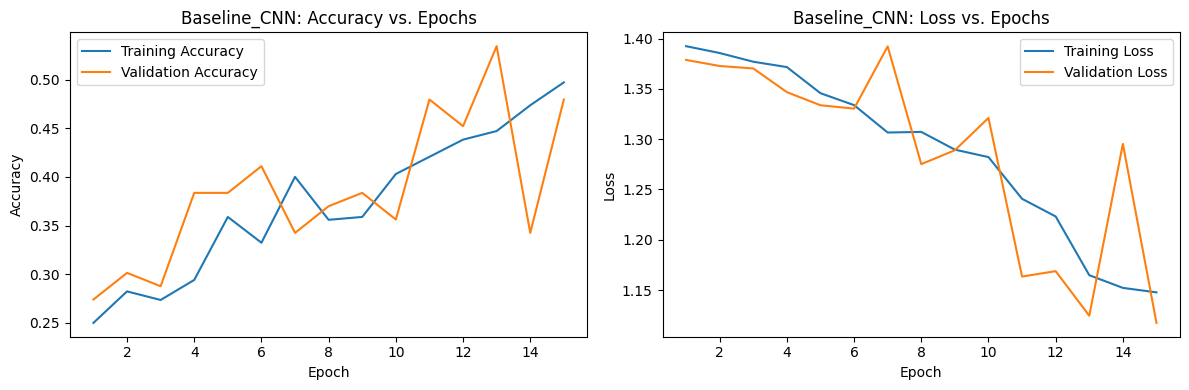

--> Baseline_CNN Best Val Acc: 0.5342

🔄 Training: MobileNetV2
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 527ms/step - accuracy: 0.4200 - loss: 1.7571 - val_accuracy: 0.7534 - val_loss: 0.6401
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.8102 - loss: 0.5424 - val_accuracy: 0.8630 - val_loss: 0.3903
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8411 - loss: 0.3975 - val_accuracy: 0.9178 - val_loss: 0.2686
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.8965 - loss: 0.2808 - val_accuracy: 0.9315 - val_loss: 0.2186
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.9177 - loss: 0.2625 - val_accuracy: 0.9178 - val_loss: 0.2688
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9369 - loss: 0.1861 - val_accuracy: 0.9452 - val_loss: 0.2221
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.8999 - loss: 0.2040 - val_accuracy: 0.9452 - val_loss: 0.1779
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9665 - loss: 0.1445 - val_accuracy: 0

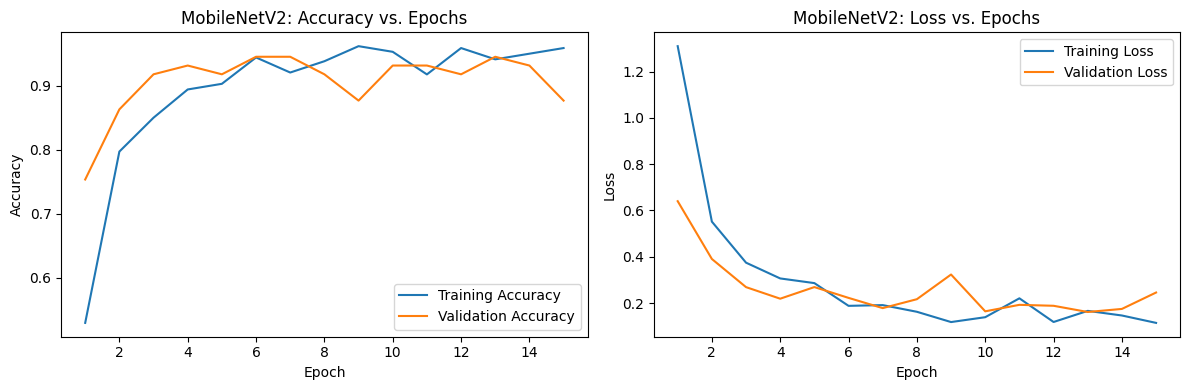

--> MobileNetV2 Best Val Acc: 0.9452

🔄 Training: ResNet50
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 597ms/step - accuracy: 0.3635 - loss: 2.1958 - val_accuracy: 0.7945 - val_loss: 0.6015
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.8022 - loss: 0.4728 - val_accuracy: 0.8904 - val_loss: 0.3067
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9115 - loss: 0.2698 - val_accuracy: 0.9041 - val_loss: 0.2345
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9330 - loss: 0.1827 - val_accuracy: 0.8493 - val_loss: 0.3019
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.8914 - loss: 0.2669 - val_accuracy: 0.9315 - val_loss: 0.1637
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9545 - loss: 0.1416 - val_accuracy: 0.9178 - val_loss: 0.1699
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9309 - loss: 0.1764 - val_accuracy: 0.9315 - val_loss: 0.1774
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9569 - loss: 0.1144 - val_accuracy: 0

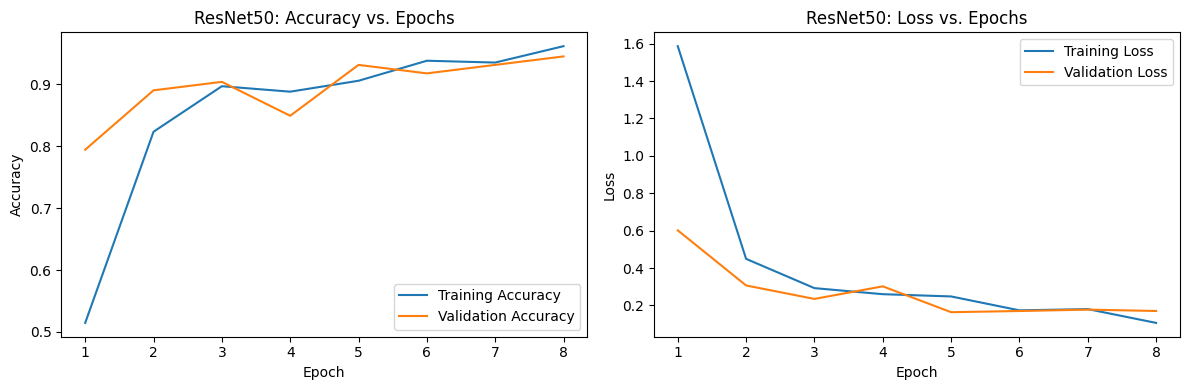

--> ResNet50 Best Val Acc: 0.9452

🔄 Training: EfficientNetB7
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4960 - loss: 1.1126 - val_accuracy: 0.8082 - val_loss: 0.6354
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.8668 - loss: 0.4348 - val_accuracy: 0.8219 - val_loss: 0.4516
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8610 - loss: 0.3430 - val_accuracy: 0.8493 - val_loss: 0.3962
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9021 - loss: 0.2610 - val_accuracy: 0.8356 - val_loss: 0.4276
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.9403 - loss: 0.2082 - val_accuracy: 0.8630 - val_loss: 0.3042
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.9430 - loss: 0.1705 - val_accuracy: 0.9041 - val_loss: 0.3022
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9414 - loss: 0.1507 - val_accuracy: 0.8767 - val_loss: 0.3105
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9594 - loss: 0.1253 - val_accuracy: 0.8

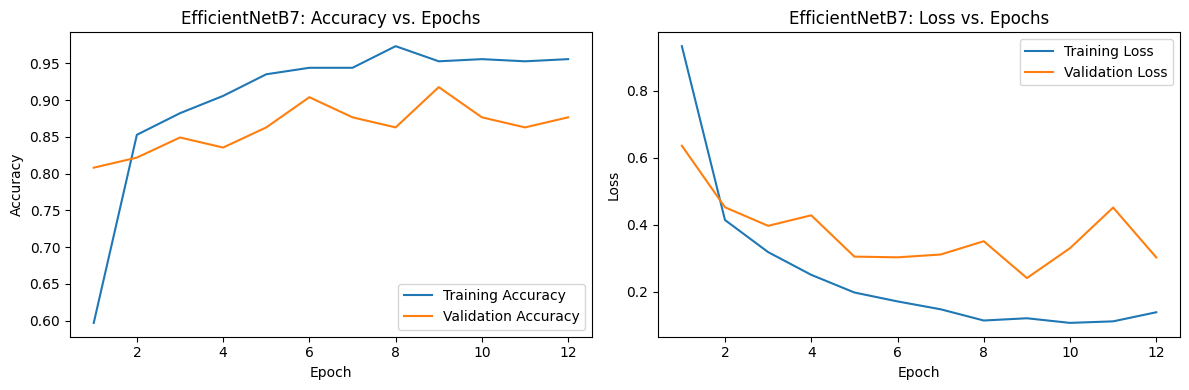

--> EfficientNetB7 Best Val Acc: 0.9178

🏆 Top Model: MobileNetV2 (Val Acc: 0.9452)


In [17]:
# =============================================================================
# 3. MODEL TRAINING LOOP & HISTORY VISUALIZATION
# =============================================================================
print("\n--- Phase 2: Model Training ---")

models_config = {
    'Baseline_CNN':   (None, None, 1./255),
    'MobileNetV2':    (MobileNetV2, mobilenet_prep, None),
    'ResNet50':       (ResNet50, resnet_prep, None), 
    'EfficientNetB7': (EfficientNetB7, efficientnet_prep, None)
}

best_val_acc = 0.0
best_model_name = ""

def plot_history(history, model_name):
    """Plots the training and validation accuracy and loss."""
    hist_df = pd.DataFrame(history.history)
    epochs = hist_df.index.values + 1
    
    plt.figure(figsize=(12, 4))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_df['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_df['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name}: Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_df['loss'], label='Training Loss')
    plt.plot(epochs, hist_df['val_loss'], label='Validation Loss')
    plt.title(f'{model_name}: Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


for name, (ModelArch, preprocess_func, rescale_val) in models_config.items():
    print(f"\n{'='*40}")
    print(f"🔄 Training: {name}")
    print(f"{'='*40}")
    
    # Generators
    if preprocess_func:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
            horizontal_flip=True, fill_mode='nearest'
        )
        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    else:
        train_datagen = ImageDataGenerator(rescale=rescale_val, rotation_range=20, horizontal_flip=True)
        val_datagen = ImageDataGenerator(rescale=rescale_val)
        
    train_gen = train_datagen.flow_from_dataframe(
        train_df, x_col='file_path', y_col='species',
        target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical'
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        val_df, x_col='file_path', y_col='species',
        target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical', shuffle=False
    )
    
    # Architecture Definition
    if name == 'Baseline_CNN':
        model = models.Sequential([
            layers.Input(shape=(224, 224, 3)),
            layers.Conv2D(32, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(CONF["TARGET_CLASSES"]), activation='softmax')
        ])
    else:
        base_model = ModelArch(weights='imagenet', include_top=False, input_shape=(224,224,3))
        base_model.trainable = False 
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(len(CONF["TARGET_CLASSES"]), activation='softmax')
        ])
        
    # Compilation & Training
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    temp_path = f"temp_{name}.keras"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(temp_path, save_best_only=True, monitor='val_accuracy')
    ]
    
    history = model.fit(train_gen, validation_data=val_gen, epochs=CONF["EPOCHS"], callbacks=callbacks, verbose=1)
    
    # Training History Visualization
    plot_history(history, name)
    
    # Quick check & save
    model.load_weights(temp_path)
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"--> {name} Best Val Acc: {acc:.4f}")
    
    if acc > best_val_acc:
        best_val_acc = acc
        best_model_name = name
        model.save('Best_Model.h5')
        # Save class indices for inference
        with open('class_indices.pkl', 'wb') as f:
            pickle.dump(train_gen.class_indices, f)

print(f"\n🏆 Top Model: {best_model_name} (Val Acc: {best_val_acc:.4f})")



--- Phase 3: Explainability for MobileNetV2 ---


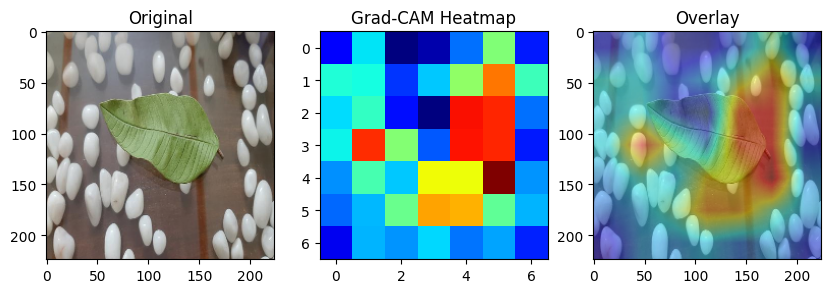

In [18]:
# =============================================================================
# 4. EXPLAINABILITY (GRAD-CAM)
# =============================================================================
print(f"\n--- Phase 3: Explainability for {best_model_name} ---")

def get_gradcam_heatmap(model, img_array, model_type):
    # Logic to find the last conv layer differs by model structure
    if model_type == 'Baseline_CNN':
        last_conv_layer = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)][-1]
        grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
        with tf.GradientTape() as tape:
            conv_outputs, preds = grad_model(img_array)
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, conv_outputs)
    else:
        # Transfer learning models (Layer 0 is base)
        base_model = model.layers[0]
        classifier_layers = model.layers[1:]
        with tf.GradientTape() as tape:
            base_output = base_model(img_array, training=False)
            tape.watch(base_output)
            x = base_output
            for layer in classifier_layers: x = layer(x)
            preds = x
            top_class_idx = tf.argmax(preds[0])
            top_class_channel = preds[:, top_class_idx]
        grads = tape.gradient(top_class_channel, base_output)
        conv_outputs = base_output

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

try:
    final_model = load_model('Best_Model.h5')
    sample_path = test_df.sample(1).iloc[0]['file_path']
    
    # Load & Preprocess Image
    img = cv2.imread(sample_path)
    img = cv2.resize(img, CONF["IMG_SIZE"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_array = np.expand_dims(img_rgb, axis=0)
    winner_config = models_config[best_model_name]
    
    if winner_config[1]: 
        img_array = winner_config[1](img_array.astype(float))
    else: 
        img_array = img_array.astype(float) * winner_config[2]
        
    heatmap = get_gradcam_heatmap(final_model, img_array, best_model_name)
    
    # Overlay
    heatmap_resized = cv2.resize(heatmap, CONF["IMG_SIZE"])
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.title("Grad-CAM Heatmap")
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)); plt.title("Overlay")
    plt.show()
    
except Exception as e:
    print(f"⚠️ Grad-CAM Skipped: {e}")



--- Phase 4: Comprehensive Evaluation Loop ---

📊 Evaluating: Baseline_CNN
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
   Computing metrics for Train/Val/Test...

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `m

 Done.


/tmp/ipykernel_38/1157343976.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray') # Diagonal line


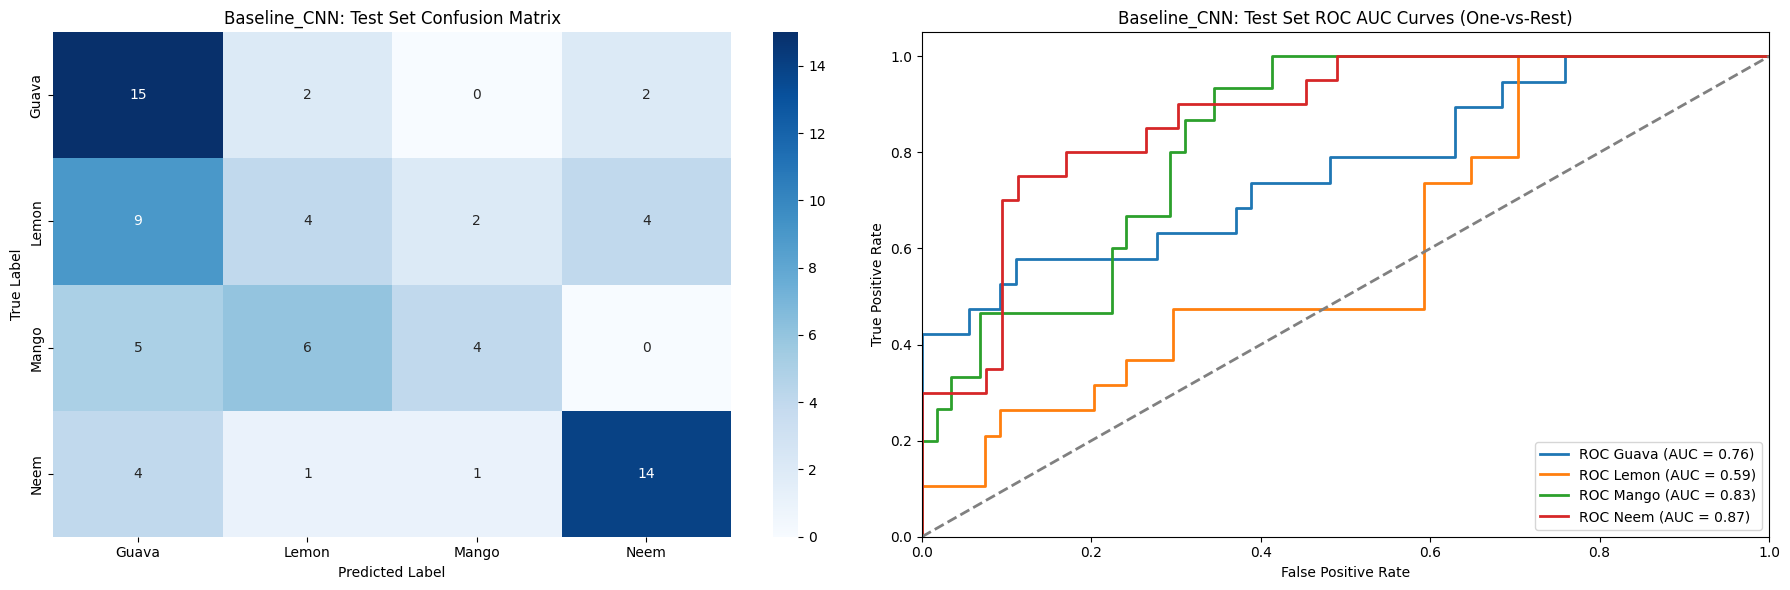


📊 Evaluating: MobileNetV2
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
   Computing metrics for Train/Val/Test...

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `m

 Done.


/tmp/ipykernel_38/1157343976.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray') # Diagonal line


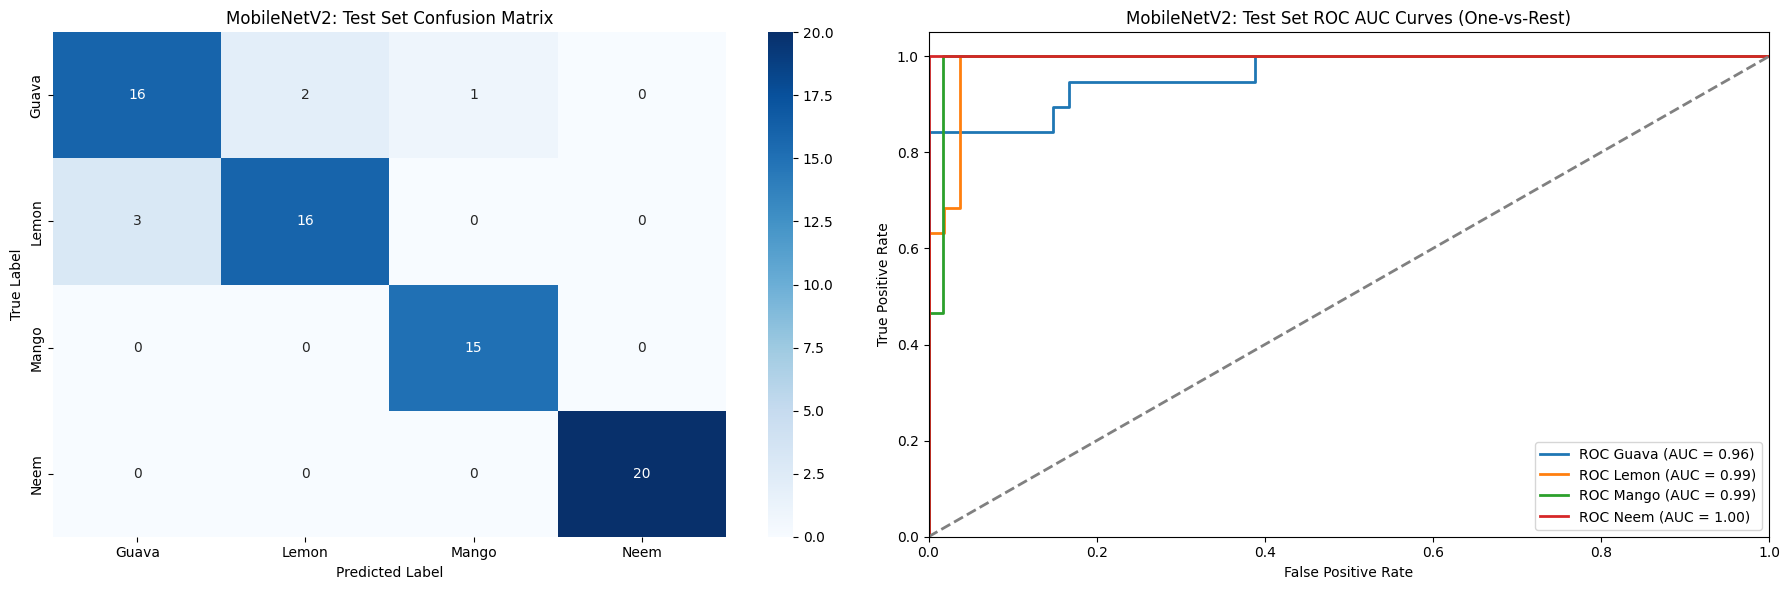


📊 Evaluating: ResNet50
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
   Computing metrics for Train/Val/Test...

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `m

 Done.


/tmp/ipykernel_38/1157343976.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray') # Diagonal line


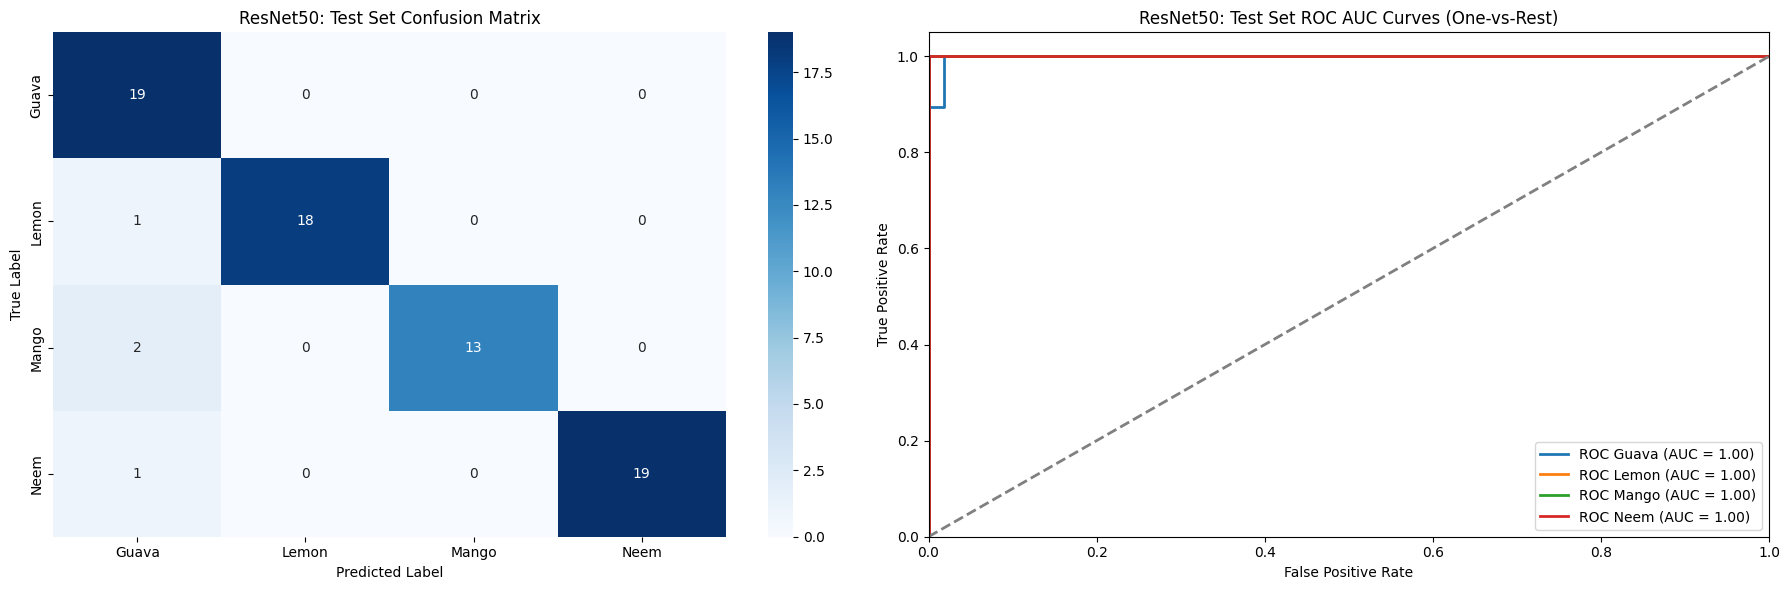


📊 Evaluating: EfficientNetB7
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
   Computing metrics for Train/Val/Test...

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `m

 Done.


/tmp/ipykernel_38/1157343976.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray') # Diagonal line


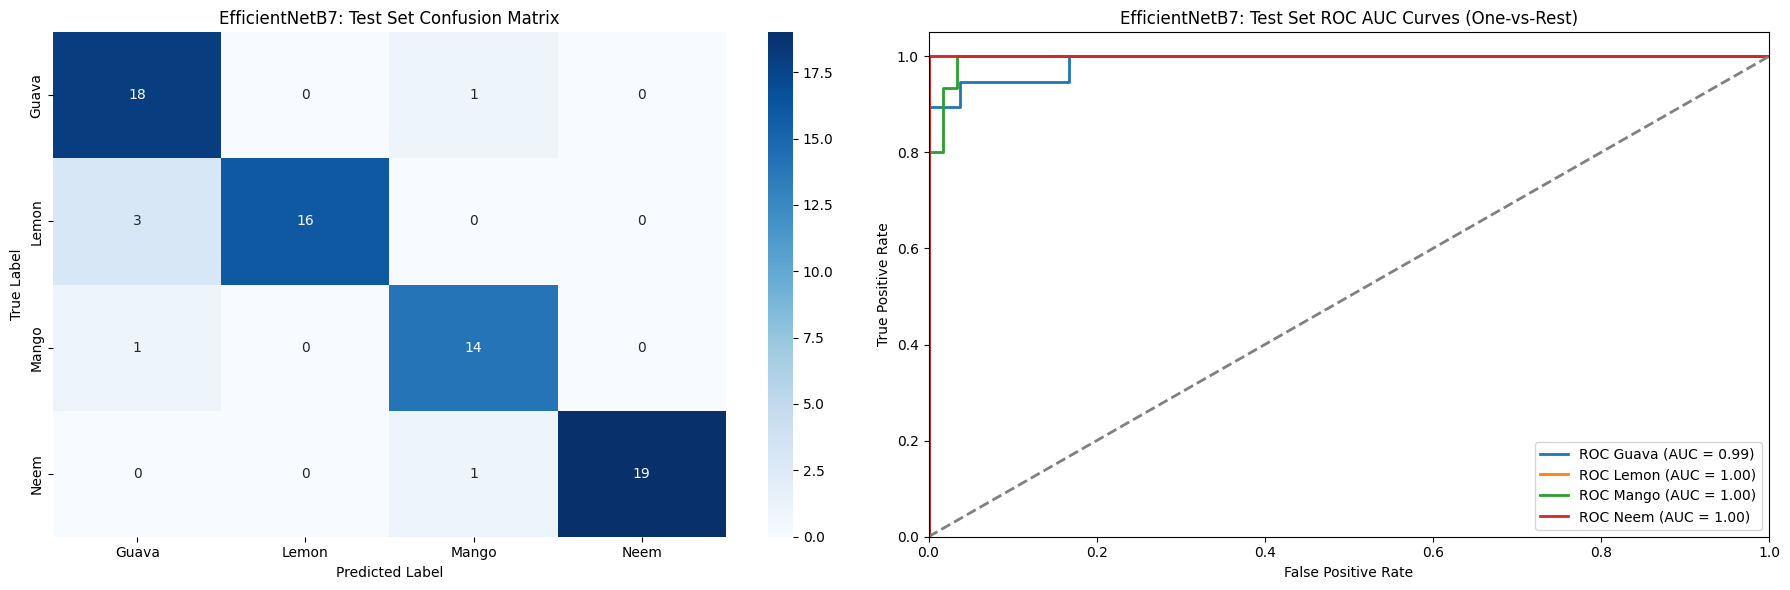

In [19]:
# =============================================================================
# 5. COMPREHENSIVE EVALUATION & VISUALIZATION
# =============================================================================
print("\n--- Phase 4: Comprehensive Evaluation Loop ---")

all_metrics = []

def plot_evaluation_visuals(y_true_labels, y_pred_labels, y_pred_probs, class_names, model_name):
    """Generates and plots Confusion Matrix and Multi-Class ROC AUC Curves."""
    
    n_classes = len(class_names)
    y_true_onehot = to_categorical(y_true_labels, num_classes=n_classes)
    
    plt.figure(figsize=(18, 6))
    
    # 1. Confusion Matrix Plot
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name}: Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 2. ROC AUC Curve Plot
    plt.subplot(1, 2, 2)
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC {class_names[i]} (AUC = {roc_auc[i]:0.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray') # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}: Test Set ROC AUC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


for name, (ModelArch, preprocess_func, rescale_val) in models_config.items():
    model_path = f"temp_{name}.keras"
    
    if not os.path.exists(model_path):
        print(f"⚠️ Skipping {name}: Weights not found.")
        continue
        
    print(f"\n📊 Evaluating: {name}")
    model = load_model(model_path)
    
    # Create Generators (Shuffle=False is mandatory for correct metrics)
    if preprocess_func:
        eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    else:
        eval_datagen = ImageDataGenerator(rescale=rescale_val)

    def get_eval_flow(dataframe):
        return eval_datagen.flow_from_dataframe(
            dataframe,
            x_col='file_path', y_col='species',
            target_size=CONF["IMG_SIZE"],
            batch_size=CONF["BATCH_SIZE"],
            class_mode='categorical',
            shuffle=False 
        )

    # Note: We only need test_gen for final report, but calculate train/val for completeness
    train_gen = get_eval_flow(train_df)
    val_gen   = get_eval_flow(val_df)
    test_gen  = get_eval_flow(test_df)
    class_names = list(test_gen.class_indices.keys())
    
    
    # Metric Calculation Function
    def calculate_metrics(model, generator, subset_name):
        # Predictions
        y_pred_probs = model.predict(generator, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = generator.classes
        
        # Basic Metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # AUC Calculation (One-vs-Rest)
        try:
            n_classes = len(generator.class_indices)
            y_true_onehot = to_categorical(y_true, num_classes=n_classes)
            auc_val = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='weighted')
        except Exception as e:
            # print(f"   AUC Error: {e}") # Keep logging clean
            auc_val = 0.0

        # Generate Text Report
        report_text = classification_report(
            y_true, y_pred, 
            target_names=class_names, 
            zero_division=0
        )
        
        return {
            f'{subset_name} Acc': acc,
            f'{subset_name} Prec': prec,
            f'{subset_name} Rec': rec,
            f'{subset_name} F1': f1,
            f'{subset_name} AUC': auc_val
        }, report_text, y_true, y_pred, y_pred_probs

    # Compute
    print("   Computing metrics for Train/Val/Test...", end="")
    train_res, _, _, _, _ = calculate_metrics(model, train_gen, "Train")
    val_res, _, _, _, _   = calculate_metrics(model, val_gen, "Val")
    test_res, test_report, y_true_test, y_pred_test, y_pred_probs_test = calculate_metrics(model, test_gen, "Test")
    print(" Done.")
    
    # Evaluation Visualization (Confusion Matrix & ROC AUC)
    plot_evaluation_visuals(y_true_test, y_pred_test, y_pred_probs_test, class_names, name)

    # Aggregate
    row = {'Model': name}
    row.update(train_res)
    row.update(val_res)
    row.update(test_res)
    row['Test Report'] = test_report
    all_metrics.append(row)

In [20]:
# =============================================================================
# 6. FINAL REPORT GENERATION
# =============================================================================
print(f"\n{'='*40}")
print("🏆 FINAL LEADERBOARD")
print(f"{'='*40}")

results_df = pd.DataFrame(all_metrics)
display_cols = ['Model', 'Train Acc', 'Val Acc', 'Test Acc', 'Test F1', 'Test AUC']
print(results_df[display_cols].round(4).to_string(index=False))

print(f"\n{'='*40}")
print("📄 DETAILED CLASSIFICATION REPORTS (TEST SET)")
print(f"{'='*40}")

for index, row in results_df.iterrows():
    print(f"\n🔹 Model: {row['Model']}")
    print(f"   Test AUC: {row['Test AUC']:.4f}")
    print("-" * 55)
    print(row['Test Report'])
    print("-" * 55)

print("\n✅ Project Complete.")


🏆 FINAL LEADERBOARD
         Model  Train Acc  Val Acc  Test Acc  Test F1  Test AUC
  Baseline_CNN     0.4706   0.5342    0.5068   0.4817    0.7637
   MobileNetV2     0.9500   0.9452    0.9178   0.9171    0.9852
      ResNet50     0.9971   0.9452    0.9452   0.9465    0.9995
EfficientNetB7     0.9559   0.9178    0.9178   0.9190    0.9963

📄 DETAILED CLASSIFICATION REPORTS (TEST SET)

🔹 Model: Baseline_CNN
   Test AUC: 0.7637
-------------------------------------------------------
              precision    recall  f1-score   support

       Guava       0.45      0.79      0.58        19
       Lemon       0.31      0.21      0.25        19
       Mango       0.57      0.27      0.36        15
        Neem       0.70      0.70      0.70        20

    accuracy                           0.51        73
   macro avg       0.51      0.49      0.47        73
weighted avg       0.51      0.51      0.48        73

-------------------------------------------------------

🔹 Model: MobileNetV2
 